# Predicting Apartment Prices in Mexico City 🇲🇽

In [2]:
import warnings

import wqet_grader

 
from glob import glob

import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.utils.validation import check_is_fitted
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from category_encoders import OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge



In [3]:
def wrangle(filepath):
    # Read CSV file into DataFrame
    df = pd.read_csv(filepath)
    # Subset to properties in '"Capital Federal"'
    mask_ba = df["place_with_parent_names"].str.contains("Distrito Federal")
    # Subset to '"apartments"'
    mask_apt = df["property_type"] == "apartment"
    # Subset to properties where '"price_aprox_usd"' < 100_000
    mask_price = df["price_aprox_usd"] < 100_000
    
    df = df[mask_ba & mask_apt & mask_price]
    
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]
    
     # Split "lat-lon" column
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
    df.drop(columns="lat-lon", inplace=True)
    
     # Get place name
    df["borough"] = df["place_with_parent_names"].str.split("|", expand=True)[1]
    df.drop(columns="place_with_parent_names", inplace=True)
    
     # Drop features with high null counts
    df.drop(columns=["floor", "expenses"], inplace=True)
    
    #Drop low- and high-Cardinality categorical variables
    df.drop(columns=["operation", "property_type", "currency", "properati_url"], inplace=True)
    
    # Drop leaky columns
    df.drop(columns=[
            'price',
            'price_aprox_local_currency',
            'price_per_m2',
            'price_usd_per_m2' 
    ], 
        inplace=True
    )
     # Drop columns with multicollinearlity 
    df.drop(columns=["surface_total_in_m2", "rooms"], inplace=True)
   

    return df

In [4]:
df = wrangle("data/mexico-city-real-estate-1.csv")
print("df shape:", df.shape)
df.head()

df shape: (1101, 5)


,price_aprox_usd,surface_covered_in_m2,lat,lon,borough
11,94022.66,57.0,23.634501,-102.552788,Benito Juárez
20,70880.12,56.0,19.402413,-99.095391,Iztacalco
21,68228.99,80.0,19.357820,-99.149406,Benito Juárez
22,24235.78,60.0,19.504985,-99.208557,Azcapotzalco
26,94140.20,50.0,19.354219,-99.126244,Coyoacán


In [5]:
files = glob("data/mexico-city-real-estate-*.csv")
files

['data\\mexico-city-real-estate-1.csv',
 'data\\mexico-city-real-estate-2.csv',
 'data\\mexico-city-real-estate-3.csv',
 'data\\mexico-city-real-estate-4.csv',
 'data\\mexico-city-real-estate-5.csv']

In [6]:
frames = [wrangle(file) for file in files]
df = pd.concat(frames, ignore_index=True)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5473 entries, 0 to 5472
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        5473 non-null   float64
 1   surface_covered_in_m2  5473 non-null   float64
 2   lat                    5149 non-null   float64
 3   lon                    5149 non-null   float64
 4   borough                5473 non-null   object 
dtypes: float64(4), object(1)
memory usage: 213.9+ KB
None


,price_aprox_usd,surface_covered_in_m2,lat,lon,borough
0,94022.66,57.0,23.634501,-102.552788,Benito Juárez
1,70880.12,56.0,19.402413,-99.095391,Iztacalco
2,68228.99,80.0,19.357820,-99.149406,Benito Juárez
3,24235.78,60.0,19.504985,-99.208557,Azcapotzalco
4,94140.20,50.0,19.354219,-99.126244,Coyoacán


In [7]:
def plot_histogram(data, ylabel, xlabel, title):
    plt.figure(figsize = (10, 6))
    plt.hist(data, edgecolor="white")
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.title(title);

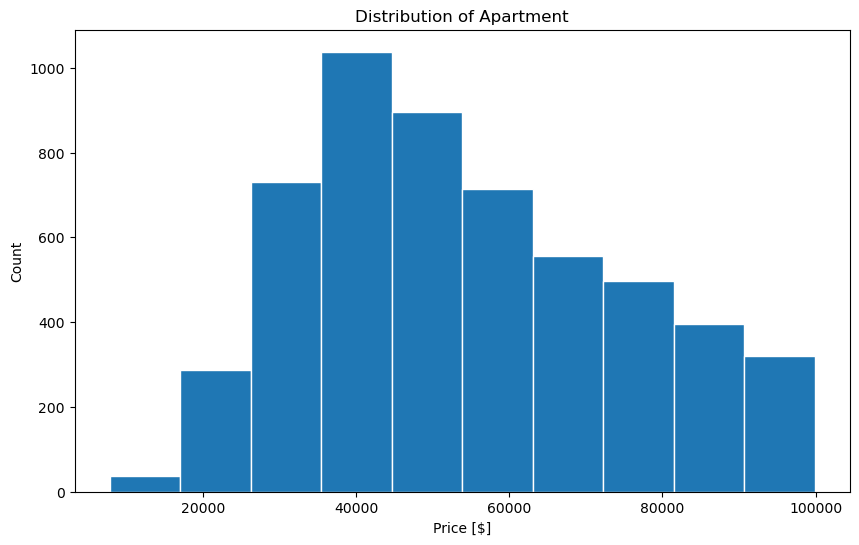

In [9]:
    plot_histogram(df["price_aprox_usd"], "Count", "Price [$]", "Distribution of Apartment")

This histogram shows the distribution of apartment prices ("price_aprox_usd") in df.

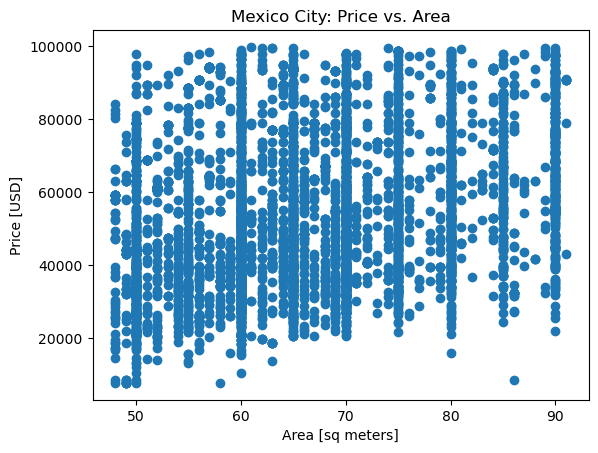

In [10]:
# Build scatter plot
plt.scatter(x=df["surface_covered_in_m2"], y=df["price_aprox_usd"])


# Label axes
plt.xlabel("Area [sq meters]")
plt.ylabel("Price [USD]")

# Add title
plt.title("Mexico City: Price vs. Area");

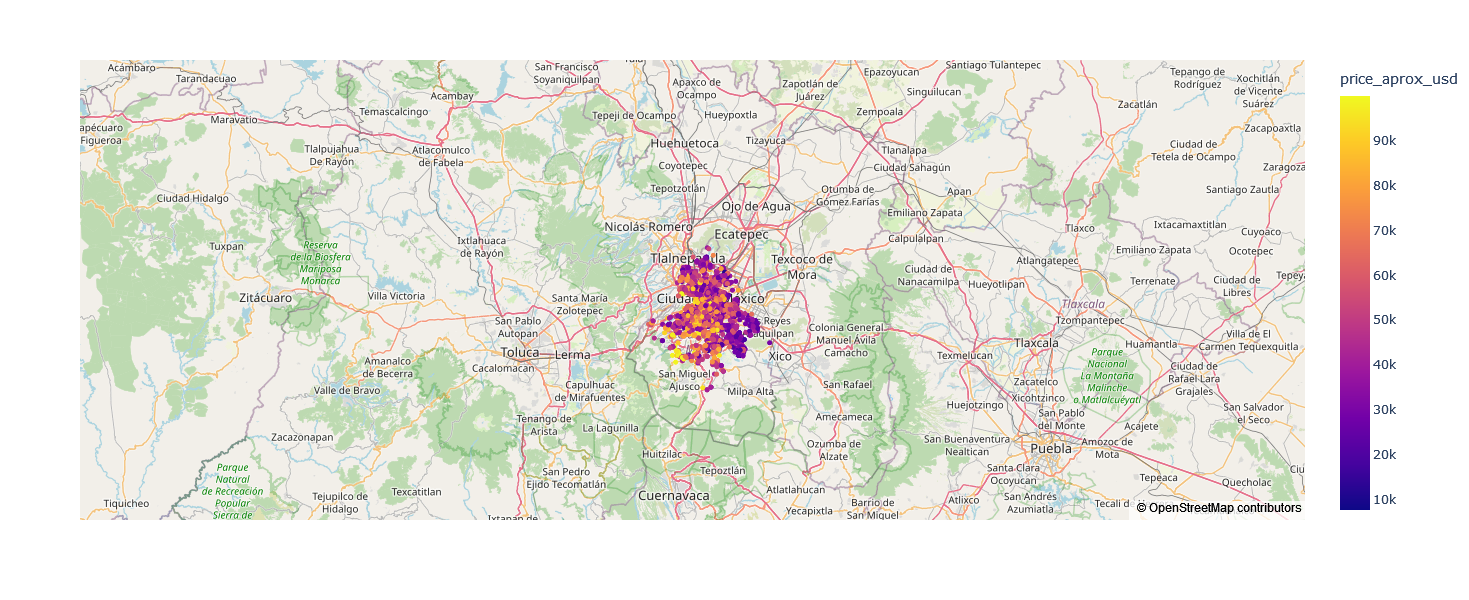

In [20]:
fig = px.scatter_mapbox(
    df,  # Our DataFrame
    lat="lat",
    lon="lon",
    width=1000,  # Width of map
    height=600,  # Height of map
    color="price_aprox_usd",
    hover_data=["price_aprox_usd"],  # Display price when hovering mouse over house
)
fig.update_layout(mapbox_style="open-street-map")

fig.show()

The Mapbox scatter plot shows the locations of the apartments in the dataset

In [13]:
features = ['surface_covered_in_m2', 'lat', 'lon', 'borough'] 
X_train = df[features]

target = "price_aprox_usd"
y_train = df[target]

In [14]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
baseline_mae = mean_absolute_error(y_train, y_pred_baseline)
print("Mean apt price:", y_mean)
print("Baseline MAE:", baseline_mae)

Mean apt price: 54246.5314982642
Baseline MAE: 17239.939475888295


In [15]:
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    Ridge()
)
# Fit model
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['borough'], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

In [16]:
X_test = pd.read_csv("data/mexico-city-test-features.csv")
print(X_test.info())
X_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1041 entries, 0 to 1040
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surface_covered_in_m2  1041 non-null   int64  
 1   lat                    986 non-null    float64
 2   lon                    986 non-null    float64
 3   borough                1041 non-null   object 
dtypes: float64(2), int64(1), object(1)
memory usage: 32.7+ KB
None


,surface_covered_in_m2,lat,lon,borough
0,60,19.493185,-99.205755,Azcapotzalco
1,55,19.307247,-99.166700,Coyoacán
2,50,19.363469,-99.010141,Iztapalapa
3,60,19.474655,-99.189277,Azcapotzalco
4,74,19.394628,-99.143842,Benito Juárez


In [17]:
y_test_pred = pd.Series(model.predict(X_test))
y_test_pred.head()

0    53538.366480
1    53171.988369
2    34263.884179
3    53488.425607
4    68738.924884
dtype: float64

In [18]:
coefficients = model.named_steps["ridge"].coef_
features = model.named_steps["onehotencoder"].get_feature_names()     #use_cat_names=True get_feature_names()  
feat_imp = pd.Series(coefficients, index=features)
feat_imp

surface_covered_in_m2               291.654156
lat                                 478.901375
lon                               -2492.221814
borough_Benito Juárez             13778.188880
borough_Iztacalco                   405.403127
borough_Azcapotzalco               2459.288646
borough_Coyoacán                   3737.561001
borough_Álvaro Obregón             3275.121061
borough_Iztapalapa               -13349.017448
borough_Cuauhtémoc                 -350.531990
borough_Tláhuac                  -14166.869486
borough_Miguel Hidalgo             1977.314718
borough_Venustiano Carranza       -5609.918629
borough_Tlalpan                   10319.429804
borough_Gustavo A. Madero         -6637.429757
borough_Xochimilco                  929.857400
borough_La Magdalena Contreras    -5925.666450
borough_Cuajimalpa de Morelos      9157.269123
dtype: float64

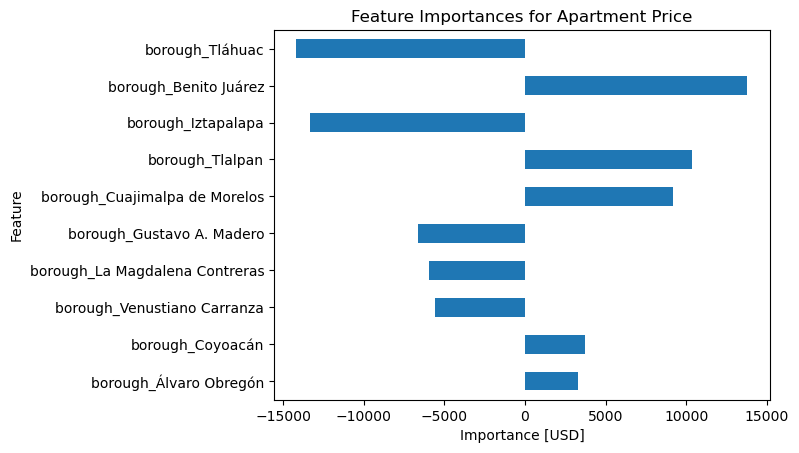

In [19]:
feat_imp.sort_values(key=abs).tail(10).plot(kind="barh")
plt.xlabel("Importance [USD]")
plt.ylabel("Feature")
plt.title("Feature Importances for Apartment Price");

The bar chart shows the 10 most influential coefficients of my model. 